# Reliability diagrams

In [1]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict
from reliability_diagrams import *

## Load the data

The results are stored in a CSV file with 3 columns: `true_label`, `pred_label`, `confidence`. For a multi-class model, the predicted label and the confidence are for the highest-scoring class.

In [2]:
csv_dir = "./results"

In [3]:
datasets = sorted(os.listdir(csv_dir))
datasets

['ImageNet_pytorch-image-models']

In [4]:
files = {}
for dataset in datasets:
    path = os.path.join(csv_dir, dataset)
    filenames = [x for x in sorted(os.listdir(path)) if x[-4:] == ".csv"]
    files[dataset] = filenames

In [5]:
files

{'ImageNet_pytorch-image-models': ['densenetblur121d.csv',
  'efficientnet_b1.csv',
  'efficientnet_b3a.csv',
  'ese_vovnet19b_dw.csv',
  'gluon_senet154.csv',
  'mixnet_m.csv',
  'mobilenetv3_large_100.csv',
  'resnet34.csv',
  'resnext50_32x4d.csv',
  'tf_inception_v3.csv']}

## Look at the results for a single model

In [6]:
dataset = "ImageNet_pytorch-image-models"
filename = files[dataset][4]
filename

'gluon_senet154.csv'

In [7]:
df = pd.read_csv(os.path.join(csv_dir, dataset, filename))
plot_name = filename[:-4] + " " + dataset

In [8]:
df.head()

,true_label,pred_label,confidence
0,0,394,0.771687
1,0,0,0.876574
2,0,758,0.303288
3,0,0,0.916573
4,0,0,0.888993


In [9]:
# Should equal the number of test examples.
len(df)

50000

In [10]:
# Sanity check: compute top-1 accuracy.
(df.true_label == df.pred_label).sum() / len(df)

0.81224

In [11]:
df.confidence.mean()

0.7615952699293569

In [12]:
y_true = df.true_label.values
y_pred = df.pred_label.values
y_conf = df.confidence.values

## Make the plot

In [13]:
# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

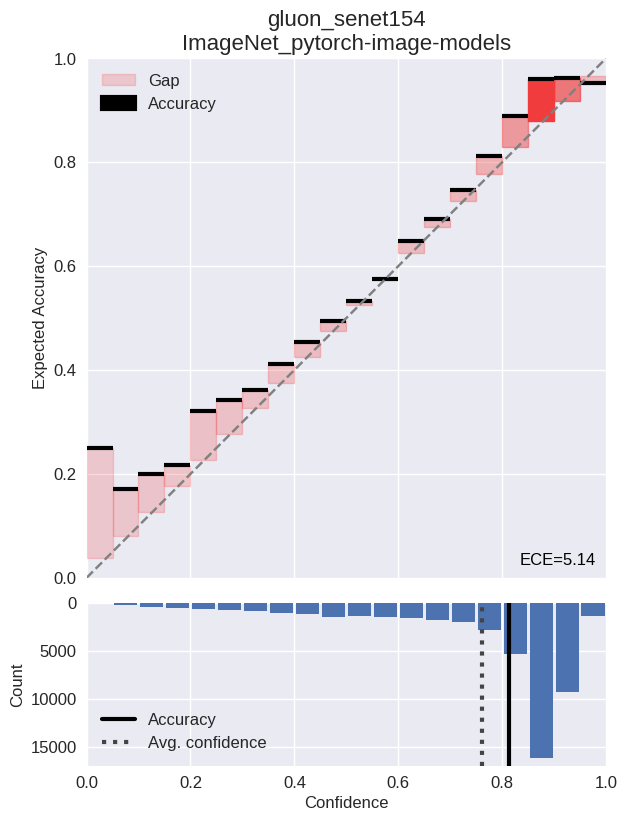

In [14]:
title = "\n".join(plot_name.split())

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=20, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

In [15]:
fig.savefig("figures/" + "_".join(plot_name.split()) + ".pdf", 
            format="pdf", dpi=144, bbox_inches="tight", pad_inches=0.2)

## Look at the bins

In [16]:
bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins=20)

In [17]:
bin_data

{'accuracies': array([0.25      , 0.17073171, 0.20050761, 0.2177264 , 0.32200647,
        0.34227331, 0.36220472, 0.41117764, 0.45338983, 0.49523161,
        0.53193033, 0.57575758, 0.64848883, 0.69013272, 0.74554707,
        0.81117117, 0.88935282, 0.95933296, 0.96246505, 0.95309168]),
 'confidences': array([0.03856731, 0.08078919, 0.12720707, 0.17585266, 0.22668784,
        0.27595821, 0.32619033, 0.37539685, 0.4259704 , 0.47451547,
        0.52537019, 0.57500926, 0.62541212, 0.675474  , 0.72602364,
        0.77703568, 0.82853699, 0.8788673 , 0.91783043, 0.96588768]),
 'counts': array([   12,   205,   394,   519,   618,   783,   889,  1002,  1180,
         1468,  1378,  1452,  1522,  1733,  1965,  2775,  5269, 16131,
         9298,  1407]),
 'bins': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'avg_accuracy': 0.81224,
 'avg_confidence': 0.7615952699293569,
 'expected_calibration_error':

## Plot reliability diagrams for all models

In [18]:
def read_results(csv_dir, dataset, filename):
    df = pd.read_csv(os.path.join(csv_dir, dataset, filename))

    y_true = df.true_label.values
    y_pred = df.pred_label.values
    y_conf = df.confidence.values

    plot_name = filename[:-4] + " " + dataset
    return plot_name, { "true_labels": y_true,
                        "pred_labels": y_pred,
                        "confidences": y_conf}

In [19]:
results = OrderedDict()
for dataset, filenames in files.items():
    for filename in filenames:
        plot_name, data = read_results(csv_dir, dataset, filename)
        results[plot_name] = data

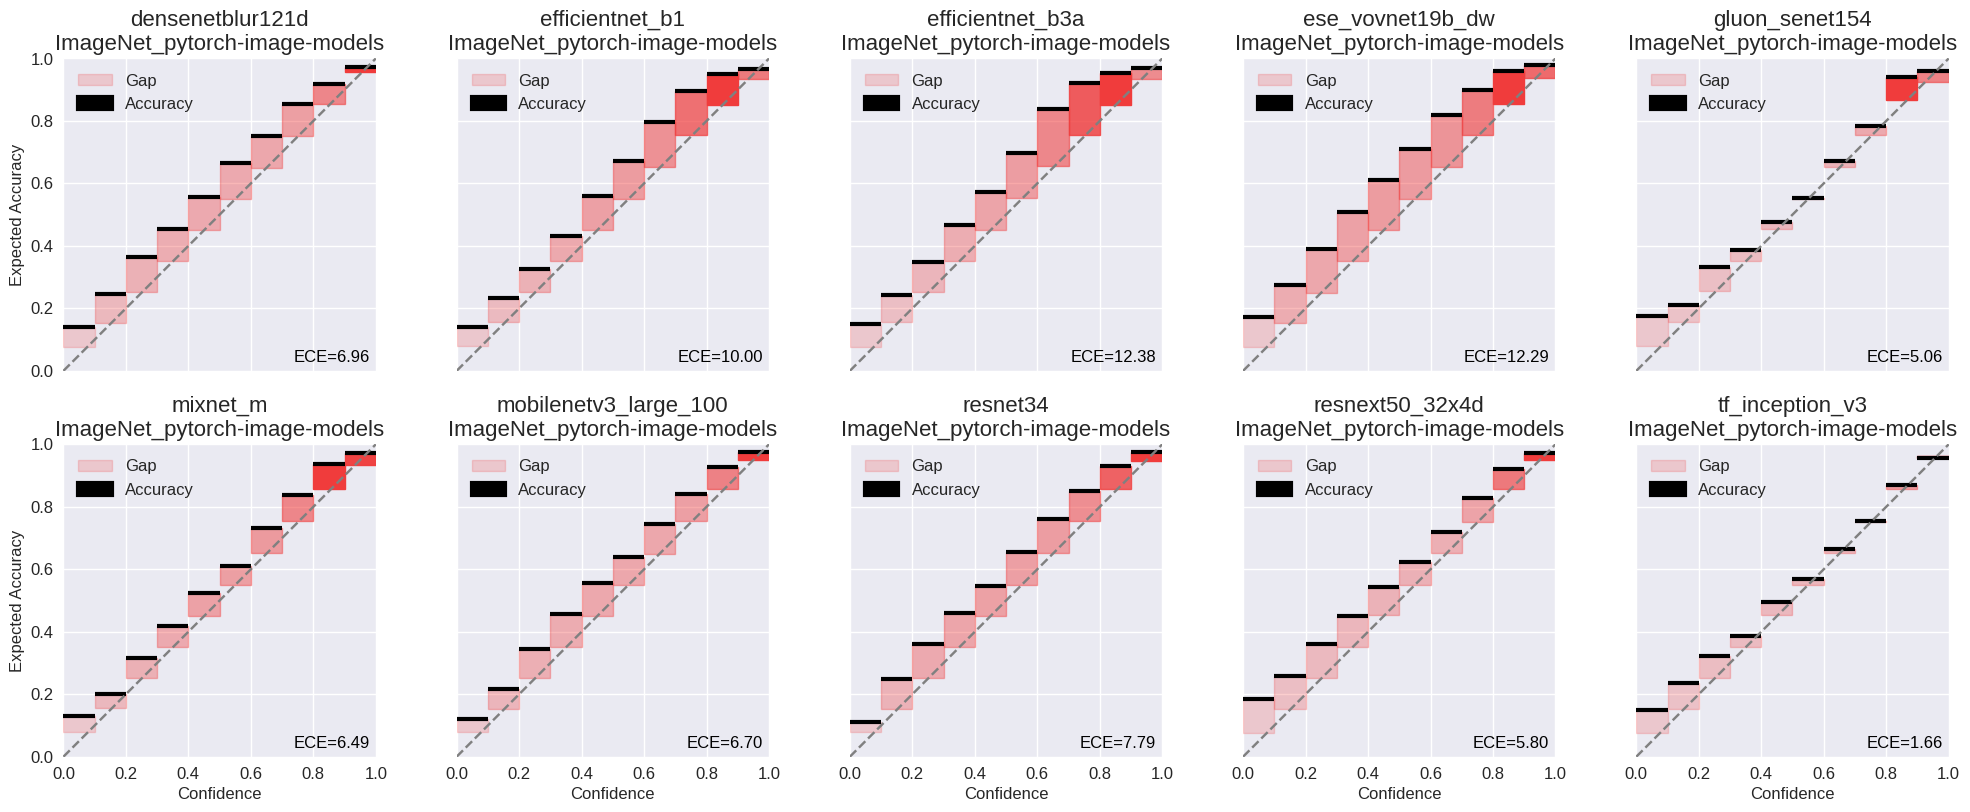

In [20]:
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=5, dpi=100, return_fig=True)

In [21]:
fig.savefig("figures/all.pdf", format="pdf", dpi=144, bbox_inches="tight", pad_inches=0.2)

In [ ]:
# TODO: maybe draw a separate graph per subdir?